In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator, MultipleLocator
import numpy as np

from astropy import constants as c

M_sun = c.M_sun.si.value

#%matplotlib widget
#%config InlineBackend.figure_format = 'retina'

# Local scripts for plotting and to compute vkep
import plots as pl

from eddy import rotationmap

## Set the system geometrical properties

In [2]:
d = 140. # pc
mstar = 2.4 # msun

PA = 0.
inc = 10.

tilt  = 0.
twist = 0.
w_r0  = 0.3#0.4 # 0.4 # 
w_dr  = 0.1#0.2 # being r0/4 doesnt affect


## Make the eddy velocity map

Create a cube object

In [3]:
path = './disk_incl10.0phi0.0_inc30.0PA45.0_r040dr10_M1.fits'
uncertainty = './disk_incl10.0phi0.0_inc30.0PA45.0_r040dr10_dM1.fits'

cube = rotationmap(path=path,
                   uncertainty=uncertainty)#, FOV=1.0)

# Get the pixel value to shift the cubes 
dpix = cube.dpix

In [4]:
# Dictionary to contain the disk parameters.
params = {}

# Start with the free variables in p0.
xlim = (0.7071428571428271, -0.7142857142856842)
ylim = (-0.7142857142857126, 0.7071428571428555)
params['x0'] = 0.0 - dpix/4 #+ (xlim[0]-xlim[1])/200
params['y0'] = 0.0 - dpix/2  #+ (ylim[1]-ylim[0])/200
params['vlsr'] = 0.
params['dist'] = d # parsec
params['PA'] = PA
params['inc'] = inc
params['mstar'] = mstar

# Warp parameters
params['w_i'] = 0
params['w_t'] = 1
params['w_r0'] = 2
params['w_dr'] = 3

p0 = [30., 45., 0.20, 0.20]

# Surface parameters
params['z0'] = 0.0

In [5]:
x0   = 0.0
y0   = 0.0
w_i = tilt
w_t = twist
w_r0 = w_r0 
w_dr = w_dr

samples = np.array([[w_i, w_t, w_r0, w_dr]])

(0.05, -0.05)

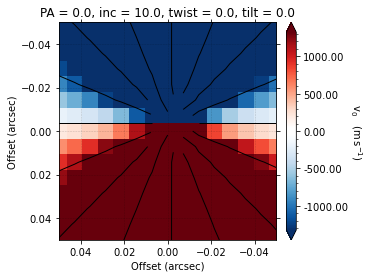

In [6]:
model0 = cube.evaluate_models(samples=samples, params=params)

# Get vmin vmax for Til's method
vmin0, vmax0 = np.nanpercentile(model0, [2, 98])
# Get the surface
fig_model0 = cube.plot_model_surface(samples,
                                     params,
                                    return_fig=True)
ax_model0 = fig_model0.get_axes()[0]

# Overplot the surface

cube.plot_model(model=model0, ax=ax_model0, return_fig=False)



ax_model0.set_title(f'PA = {PA}, inc = {inc}, twist = {twist}, tilt = {tilt}')
xlim = ax_model0.get_xlim()
ylim = ax_model0.get_ylim()

ax_model0.set_xlim(0.05, -0.05)
ax_model0.set_ylim(0.05, -0.05)
#print(xlim, ylim)
#print(np.nanmax(model))
#fig_model.savefig(f'eddy_PA{PA}inc{inc}T{twist}t{tilt}.pdf', dpi=500, bbox_inches='tight')

#print(model.shape)
#print(model.shape[0])

## Make the velocity map with Til's method

(0.05, -0.05)

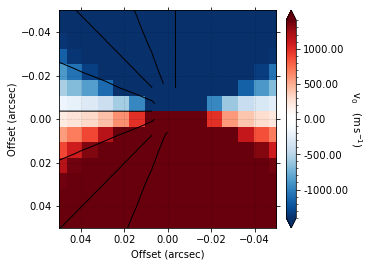

In [13]:
### General definitions of disk parameters
params1=params

params1['x0'] = 0.0
params1['y0'] = 0.0
params1['shadowed'] = True
model1 = cube.evaluate_models(samples=samples, params=params1)

# Get vmin vmax for Til's method
vmin, vmax = np.nanpercentile(model1, [2, 98])
# Get the surface
fig_model1 = cube.plot_model_surface(samples,
                                    params1,
                                    return_fig=True)
ax_model1 = fig_model1.get_axes()[0]

xlim1 = ax_model1.get_xlim()
ylim1 = ax_model1.get_ylim()

# Overplot the surface

cube.plot_model(model=model1, ax=ax_model1, return_fig=False)

ax_model1.set_xlim(0.05, -0.05)
ax_model1.set_ylim(0.05, -0.05)

# Analytical velocity map

In [8]:
from scipy.interpolate import griddata

In [79]:
# Analytical solution
x = np.linspace(xlim1[0], xlim1[1], 200) + dpix/2
y = np.linspace(ylim1[0], ylim1[1], 200) + dpix/2

X, Y = np.meshgrid(x, y, indexing='ij')

# Deproject coords
X0 = X
Y0 = Y / np.cos(np.radians(inc))

R = np.hypot(X0, Y0)
PHI = np.arctan2(Y0, X0)

v0_a = pl._proj_vphi(R, np.zeros_like(R), inc, mstar, PHI, d)

In [80]:
# Velocity with deprojection
rdisk = np.hypot(X0, Y0)
tdisk = np.arctan2(Y0, X0)

disk = (X0.flatten(), Y0.flatten())
grid = (x[None, :], y[:, None]) # Check xaxis definition
r_obs = griddata(disk, rdisk.flatten(), grid,
                 method='linear')
t_obs = griddata(disk, tdisk.flatten(), grid,
                 method='linear')
#
v0_a = pl._proj_vphi(r_obs, np.zeros_like(r_obs), inc, mstar, t_obs + np.pi/2, d)

# Create residual plots

Text(0.5, 1.0, 'LEFT - RIGHT')

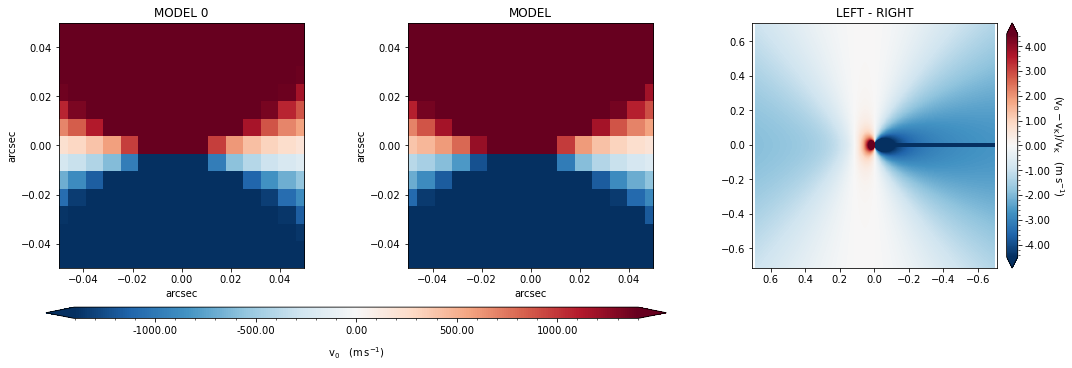

In [92]:
#img_v_flip = np.flip(img_v)

residual = model0-model1
residual = (model0-v0_a)/v0_a * 100
#residual = (model1-v0_a)

extent = [xlim[0], xlim[1], ylim[0], ylim[1]]

vminr, vmaxr = np.nanpercentile(residual, [2, 98])

kwargs0 = {'origin':'lower', 'vmin':vmin, 'vmax':vmax}
kwargs1 = {'origin':'lower', 'vmin':vmin, 'vmax':vmax}
kwargs2 = {'origin':'lower', 'vmin':-vmaxr*30, 'vmax':vmaxr*30}

figR, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

im0 = ax0.imshow(model1, cmap='RdBu_r', extent=extent, **kwargs0)
im1 = ax1.imshow(v0_a, cmap='RdBu_r', extent=extent, **kwargs1)
im2 = ax2.imshow(residual, cmap='RdBu_r', extent=extent, **kwargs2)

# AX1
lx = 0.05
ly = 0.05
center = 0
ax0.set_title(f'MODEL 0')
ax0.set_xlim(center-lx, center+lx)
ax0.set_ylim(center-ly, center+ly)
ax0.set_xlabel('arcsec')
ax0.set_ylabel('arcsec')


ax1.set_title(f'MODEL')
ax1.set_xlim(center-lx, center+lx)
ax1.set_ylim(center-ly, center+ly)
ax1.set_xlabel('arcsec')
ax1.set_ylabel('arcsec')

cb0 = figR.colorbar(im0, ax=(ax0, ax1), extend='both', pad=0.03, format='%.2f', fraction=0.046, location='bottom', aspect=50)
cb0.set_label(label=r'${\rm v_{0} \quad (m\,s^{-1})}$', rotation=0, labelpad=10)
cb0.minorticks_on()


# AX3
cb2 = figR.colorbar(im2, ax=ax2, extend='both', pad=0.03, format='%.2f', fraction=0.046)
#cb2.set_label(label=r'${\rm \Delta v_{0} \quad (m\,s^{-1})}$', rotation=270, labelpad=15)
cb2.set_label(label=r'${\rm (v_{0} - v_{K})/v_{K} \quad (m\,s^{-1})}$', rotation=270, labelpad=15)
cb2.minorticks_on()

ax2.set_title("LEFT - RIGHT")
#ax3.set_xlim(-lx, lx)
#ax3.set_ylim(-ly, ly)

#figR.savefig(f'residualR-T_PA{PA}inc{inc}T{twist}t{tilt}.pdf', dpi=500, bbox_inches='tight')